<a href="https://colab.research.google.com/github/HarolReyes0/TSP-solved-by-Genetic-Algorithm/blob/main/TCP_con_algoritmos_geneticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Solving the TCP problem using genetic algorithm

Harol Reyes 2022-0380


In [ ]:
!pip install iteration_utilities

In [ ]:
import numpy as np
import random
from iteration_utilities import duplicates
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
class Graph:

  def __init__(self):
    self.distance_matrix = None
    self.nodes = {}

  def _init_distance_matrix(self, n):
    """
      Initialization of the distance matrix.

      Input:
            n: Number of nodes.
      Output:
            A matrix n x n full of infinite numbers.
    """
    self.distance_matrix = np.full((n,n), np.inf)

  def add_node(self, node_name):
    """
      Create a dictionary with the node name and a positional value.

      Inputs:
            node_name: The name of all the nodes.
      Output:
            A dictionary with the node name and a positional value

    """
    self.nodes[node_name] = len(self.nodes)

  def add_edge(self, node_a, node_b, dist):
    """
      Adds the edges and edges values to the matrix.
      inputs: node_a: a node.
              node_b: the node that wants to be connected.
              dist: the distance between nodes.

      Output: A matrix filled up with the edges values (distance).
    """
    self.distance_matrix[self.nodes[node_a]][self.nodes[node_b]] = dist
    self.distance_matrix[self.nodes[node_b]][self.nodes[node_a]] = dist

  def transform_txt(self, path):
    """
      Open and read the txt file, extract all the nodes names and makes a list
      with the edges.

      Inputs:
            Path: Where the txt file is store at.
      Output:
            nodes_names: A dictionary of all nodes found in the file)
            raw_nodes: edge of the nodess and its weight)
    """

    self.text = open(path)
    self.text = self.text.read()

    #Deliting the jumps
    self.nodes_names = self.text.replace("\n", "")
    #Getting the unique values and sorting them
    self.nodes_names = list(set([digit for digit in self.nodes_names
                          if not digit.isdigit() and digit.isalpha()]))
    self.nodes_names.sort()

    #Formating the raw data to create the following format [Node_a, Node_b and distance]
    self.edges = self.text.split("\n")

    return self.nodes_names, self.edges

  def graph_constructer(self, path):
    """
      This function inplement all the constructors to complete the process of
      getting the data and transform it in to a distance matrix.
    """
    self.nodes_names, self.edges = self.transform_txt(path)
    self._init_distance_matrix(len(self.nodes_names))

    for node_name in self.nodes_names:
      self.add_node(node_name)
    for edge in self.edges:
      #Takes values from position 0,2,3 (Node_a, Node_b and distance) and adds the edges
      self.add_edge(edge[0],edge[2],edge[4])

    for node in range(len(self.nodes_names)):
      self.distance_matrix[node][node] = 0

  def floyd_warshall(self):
    """
      This function runs Floyd Warhall's algorithm, to find the shortest rute,
      through the nodes.
    """

    for k in range(len(self.distance_matrix[0])):
      for i in range(len(self.distance_matrix[0])):
        for j in range(len(self.distance_matrix[0])):
          if self.distance_matrix[i][j] > self.distance_matrix[i][k] + self.distance_matrix[k][j]:
            self.distance_matrix[i][j] = self.distance_matrix[i][k] + self.distance_matrix[k][j]

#Genetic algorithm

In [ ]:
class Individual():
  """
    This class creates the genotype of a single individual.
  """
  def __init__(self, genotype = None):
    """
      This function initialize the genotype and the distance matrix.

      Inputs:
             distance_matrix: distance matrix after going through the Floyd
             Warshall algorithm
    """
    self.__genotype = genotype

  def __create_genotype__(self, gen_amount):
    """
      This function creates the genotype.

      Inputs:
             gen_amount: amount of genes in the genotype.
    """
    #Creating a list with the amount of genes needed.
    self.__genotype = np.arange(gen_amount)
    #Shuffuling the list to create variety.
    np.random.shuffle(self.__genotype)

  def __get_fitness_score__(self,distance_matrix):
    """
      This function calculates the fitness score. In this example it calculates
      the distance traveled.

      Inputs:
            distance_matrix: A matrix with the distance of all nodes.
    """
    self.__score = 0
    #Calculates the distance by accessing the current gen and the next gen
    #in the distance matrix.
    for gen in range(len(self.__genotype)-1):
      self.__score += distance_matrix[self.__genotype[gen]][self.__genotype[gen + 1]]

    return self.__score #Returns the score

  def __mutation__(self, mutation_rate):
    """
      This function desides based on probabilistics if the gen is going to be
      mutated.

      Outputs:
              Genotype mutated or without mutation.
    """
    self.__mutation_rate = mutation_rate

    #Calculate the probability that the genotype is mutated
    if self.__mutation_rate <= random.randint(0,100):
      #Selects two random genes.
      self.__gen_mutated = random.sample([x for x in range(len(self.__genotype))], k = 2)
      #Saves the allele
      self.first_allele = self.__genotype[self.__gen_mutated[0]]
      self.second_allele = self.__genotype[self.__gen_mutated[1]]
      #Makes the changes
      self.__genotype[self.__gen_mutated[1]] = self.first_allele
      self.__genotype[self.__gen_mutated[0]] = self.second_allele

    else:
      pass

  def get_genotype(self):
    return list(self.__genotype)


In [ ]:
class Population(Individual):
  """
    This class creates the population.

    Inputs:
           Individuals: class to create the genotype of an individual.
  """
  def __init__(self, distance_matrix):
    """
      This function initialize the population.
    """
    self.__population = {}
    self.__parents = None
    self.__distance_matrix = distance_matrix

  def create_population(self, population_amount):
    """
      This function creates the population and the genotype from each individual.

      Inputs:
             population_amount: amount of individuals that will be created.
             gen_amount: amount of genes in the genotype.
    """
    for individual in range(population_amount): #Creating each individual
      #Initializing the individual and alamcenating it in a dictionary.
      self.__population[individual] = Individual()
      #Creating the genotype of the desired individual.
      self.__population[individual].__create_genotype__(len(self.__distance_matrix[0]))

  def __show_fitness__(self, population_scores):
    """
       This function prints the basics start of the algorithm.

       Inputs:
              population_scores: Population fitness scores.

       Outputs:
              Best fitness score, best solution and the average of all fitness
              scores.
    """
    self.x = population_scores
    self.__bets_score = self.x[0][1]
    self.__average_score = np.mean([x[1] for x in self.x])
    print('\n', "--Information--", '\n')
    print("Best score: ", self.__bets_score)
    print("Best solution: ", self.__population[self.x[0][0]].get_genotype())
    print("Average fitness score: ", self.__average_score)

    return self.__bets_score, self.__average_score

  def fitness(self):
    """
      This function calculates the fitness score of each element of the poblation.
    """

    #Creating a dicionary with the score of each individual
    self.fitness_scores = {individual:self.__population[individual]\
                           .__get_fitness_score__(self.__distance_matrix)
                           for individual in range(len(self.__population))}

    #Returning a sorted list with the individuals scores in ascending oder.
    self.__individual_score = sorted(self.fitness_scores.items(),
                                     key=lambda x: x[1], reverse=False)

    self.__bets_score, self.__average_score = self.__show_fitness__(self.__individual_score)

    #Slicing the score population in to the best half.
    self.__parents = self.__individual_score[:len(self.__population)//2]
    #obtening the clases from those individual.
    self.__parents = [self.__population[x].get_genotype()
                      for x in [x[0] for x in self.__parents]]

    return self.__bets_score, self.__average_score

  def __partially_mapped__(self, first_parent, second_parent):
    """
      This function realize a partially mapped crossover.

      Inputs:
             first_parent: Parent A that wants to be crossed.
             second_parent: Parent B that wants to be crossed.

      Outputs:
              Two new genotypes.
    """
    #Difining the cut points.
    self.__point = len(first_parent)//2

    #Mapping the values that will be used in the algorithm.
    self.map = {first_parent[x]: second_parent[x]
                for x in range(len(first_parent))}

    #Mixing the genes from both parents.
    self.__first_child = list(first_parent[self.__point:]) + list(second_parent[:self.__point])
    self.__second_child = list(first_parent[:self.__point]) + list(second_parent[self.__point:])



    #Checking both childs to see if they are correct.
    for child in [self.__first_child, self.__second_child]:
      #Getting the duplicate alleles
      self.__duplicated_alleles = list(duplicates(child))

      #While the genotype has duplicate values do the following.
      while len(self.__duplicated_alleles) > 0:
        for gen in range(len(first_parent)):
          #Check the position of the duplicate gen.
          if child[gen] in self.__duplicated_alleles:
            #Map the gene.
            child[gen] = self.map[child[gen]]
          #verify if there's not any duplicate gene.
          self.__duplicated_alleles = list(duplicates(child))

    return self.__first_child, self.__second_child

  def __update_population__(self, population):
    """
      This function takes the parents and childs and makes a new population.

      Inputs:
            Population: parents and childs.

      Outputs:
              New dictionary with the population
    """
    self.__population = {}
    i = 0

    for individual in population: #Iterating throught the individuals
      #Initializing the individual and alamcenating it in a dictionary.
      self.__population[i] = Individual(individual)
      i += 1

  def __random_parent_selection__(self):
    """
       This function randomly selects two parents to be crossed.

       Outputs:
              The genotype of both parents.
    """

    #Choose randomly the parents and returns it.
    return random.choice(self.__parents), random.choice(self.__parents)

  def __top_botton_parent_selection__(self):
    """
        This function selects the parents based on their fitness ranking.

        Outputs:
              The genotype of both parents.
    """

    #if the list's len is not pair it duplicates the first parent.
    if len(self.__parents_copy) % 2 != 0:
      self.__parents_copy.append(self.__parents_copy[0])

    #Choose the first and second parent, returns it and eliminates it from the list.
    self.parent_a = self.__parents_copy[0]
    self.parent_b = self.__parents_copy[1]

    del self.__parents[0:2]
    return self.parent_a, self.parent_b

  def crossover(self, selection_methood = 0):
    """
        This functions make the individuals crossover.

        Inputs:
               selection_methood: methood to choose the parents to make the
               crossover.

               0 -> Random selection.
               1 -> Top Button selection.

        Outputs:
                list of new childs and parents.
    """

    #Getting the parents
    self.__childs = []
    self.__parents_copy = self.__parents.copy()
    if selection_methood == 0:
      self.__selection = self.__random_parent_selection__
    else:
      self.__selection = self.__top_botton_parent_selection__

    #while the poblation isn't completed do crossovers.
    while len(self.__childs) < len(self.__population)- len(self.__childs):
      #Choosing the parents.
      self.__first_parent, self.__second_parent = self.__selection()

      #getting the crossover results.
      self.__first_child, self.__second_child = self.__partially_mapped__(
                                                      self.__first_parent,
                                                     self.__second_parent)
      #Saving the new solution as childrens
      self.__childs.append(self.__first_child)
      self.__childs.append(self.__second_child)

    self.__update_population__(list(self.__childs) + list(self.__parents))

  def mutation(self, mutation_rate):
    for individual in self.__population.values():
      individual.__mutation__(mutation_rate)

  def get_population(self):
    """
      This function returns the population,
    """
    return self.__population


##Sandbox

In [ ]:
def stats(best_scores, average_scores):
  """
    This function creates a line chart to view the evolution

    Inputs:
            best_scores: list of the best scored individuals.
            average_scores: list of the average score through the iterations.

    Outputs:
            A line chart with the best scores over the iterations.
  """
  #Creating the x axis
  x = [x for x in range(len(best_scores))]

  plt.figure(figsize=(15,5))
  #Adding labels
  plt.title("Score Evolution")
  plt.xlabel("Iterations")
  plt.ylabel("Scores")

  #adding the lines to the chart.
  sns.lineplot(x = x, y = best_scores, label = "Best solution")
  sns.lineplot(x = x, y = average_scores, label="Average")

  plt.show()

In [ ]:
def memory_usage_psutil():
    # return the memory usage in MB
    import psutil
    import os
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / float(2 ** 20)
    return mem

In [ ]:
def solver(graph_path, population_amount, mutation_rate, iteration_amount, selection_methood = 0):
  """
    This function solve the Traveler Sales Person problem using genetic algorithm.

    Inputs:
          graph_path: path where the graph is located.
          population_amount: amount of solutions that wants to be generated.
          mutation_rate = value to perform a mutation.
          iteration_amount = amount cicles that the algorithm will perform.

    Outputs:
            A line chart with the best scores over the iterations.
  """

  #initializing storage methoods
  best_scores = []
  average_scores = []
  start = time.time()

  #Constructing the graph
  g = Graph()
  g.graph_constructer(graph_path)
  g.floyd_warshall()
  p = Population(g.distance_matrix)

  #initializing the first population
  p.create_population(population_amount)

  #Starting the evolution
  for iteration in range(iteration_amount):
    best_score, average_score = p.fitness()
    p.crossover(selection_methood)
    p.mutation(100 - mutation_rate)

    #adding the scores in to their lists
    best_scores.append(best_score)
    average_scores.append(average_score)

  #Showing the evolution plot.
  stats(best_scores, average_scores)
  end = time.time()
  print("Total time to perform the script: ", end - start)
  print("Memory highest peak: ", memory_usage_psutil())

##Playground


 --Information-- 

Best score:  54.0
Best solution:  [0, 9, 8, 4, 6, 1, 3, 2, 5, 7]
Average fitness score:  64.2

 --Information-- 

Best score:  54.0
Best solution:  [0, 9, 8, 4, 6, 1, 3, 2, 5, 7]
Average fitness score:  58.36363636363637

 --Information-- 

Best score:  53.0
Best solution:  [7, 6, 0, 1, 5, 2, 4, 8, 9, 3]
Average fitness score:  56.0

 --Information-- 

Best score:  53.0
Best solution:  [7, 6, 0, 1, 5, 2, 4, 8, 9, 3]
Average fitness score:  55.36363636363637

 --Information-- 

Best score:  53.0
Best solution:  [7, 6, 0, 1, 5, 2, 4, 8, 9, 3]
Average fitness score:  54.90909090909091

 --Information-- 

Best score:  53.0
Best solution:  [7, 6, 0, 1, 5, 2, 4, 8, 9, 3]
Average fitness score:  54.81818181818182

 --Information-- 

Best score:  53.0
Best solution:  [7, 6, 0, 1, 5, 2, 4, 8, 9, 3]
Average fitness score:  54.63636363636363

 --Information-- 

Best score:  53.0
Best solution:  [7, 6, 0, 1, 5, 2, 4, 8, 9, 3]
Average fitness score:  55.0

 --Information-- 

Bes

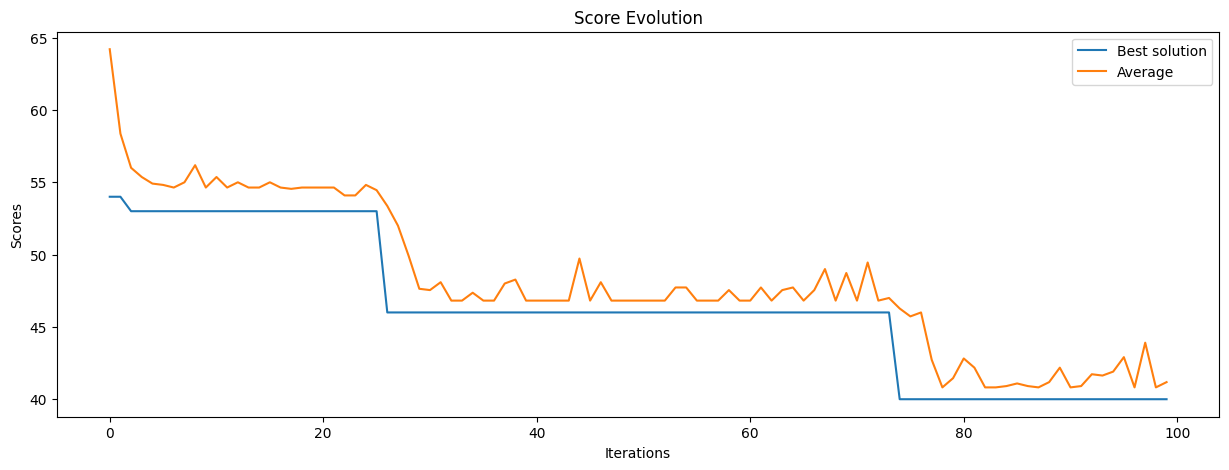

Total time to perform the script:  1.0378484725952148
Memory highest peak:  279.55859375


In [ ]:
solver('/content/GA Facil.txt', 10, 5, 100)